<a href="https://colab.research.google.com/github/lys678/AIFFEL_QUEST/blob/main/DLton/DLton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 9.5 MB/s eta 0:00:00


In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.8 MB/s eta 0:00:00


In [ ]:
def uniform_soup(model_paths, test_ds, model_fun, evaluate_fun, disable_tqdm = False):
    """
    "Uniform Soup" 모델과 테스트 데이터셋(test set)에서의 정확도를 반환
    Args:
    model_paths: 저장된 모델의 경로들의 리스트
    test_ds: 테스트 데이터셋 (TFDS 포맷)
    model_fun: 모델을 생성하는 함수
    evaluate_fun: 모델을 평가하는 함수
    disable_tqdm: TQDM 진행바(progress bar)를 비활성화할지 결정하는 값
    """
    # 각 모델의 가중치를 저장할 것입니다.
    soups = []

    # TensorFlow 백엔드의 세션을 초기
    tf.keras.backend.clear_session()
    # model_fun 함수를 사용하여 새로운 모델 인스턴스를 생성
    model = model_fun()

    # model_paths에 있는 모든 모델에 대해 다음을 수행
    for path in tqdm(model_paths, disable=disable_tqdm):

        # 해당 경로의 모델 가중치를 로드
        model.load_weights(path)

        # 로드된 모델의 가중치를 numpy 배열로 변환
        soup = [np.array(weights) for weights in model.weights]
        # 변환된 가중치를 soups 리스트에 추가
        soups.append(soup)

    # 모든 모델의 가중치를 평균내어 mean_soup을 계산
    mean_soup = np.array(soups).mean(axis = 0)

    # 새로운 평균 가중치(mean_soup)를 기존 모델의 가중치로 설정
    for w1, w2 in zip(model.weights, mean_soup ):
        tf.keras.backend.set_value(w1, w2)

    # 평균 가중치를 적용한 모델의 성능을 테스트 데이터셋에서 평가
    accuracy =  evaluate_fun(model, test_ds)
    # 평가된 정확도와 모델을 반환합니다.
    return model, accuracy

In [ ]:
def greedy_soup(model_paths, test_ds, model_fun, evaluate_fun):
    """
    Returns Greedy Soup model and accuracy on test set
    Args:
    model_paths: 저장된 모델의 경로들의 리스트
    test_ds: 테스트 데이터셋 (TFDS 포맷)
    model_fun: 모델을 생성하는 함수
    evaluate_fun: 모델을 평가하는 함수
    """
    # 첫 번째 모델(성능이 가장 좋은 것으로 가정)을 사용하여 초기 'soup'(모델의 조합)을 생성
    soups =  [model_paths[0]]

    # TensorFlow 백엔드 세션을 초기화
    tf.keras.backend.clear_session()
    # 새로운 모델 인스턴스를 생성
    model = model_fun()

    # 가장 성능이 좋은 모델의 가중치를 로드
    model.load_weights(model_paths[0])

    # 테스트 데이터셋에 대한 초기 모델의 성능을 평가
    score_final = evaluate_fun(model,test_ds)

    # 남은 모델들에 대해 반복
    for path in tqdm(model_paths[1:]):

        # 임시 'soup'을 생성하여 현재 모델을 추가
        temp_soup =  soups.copy()
        temp_soup.append(path)

        # 임시 'soup'의 성능을 평가
        model, score = uniform_soup(temp_soup,test_ds,model_fun, evaluate_fun, disable_tqdm= True)

        # 임시 'soup'의 성능이 현재까지의 최고 성능보다 좋다면, 이를 메인 'soup'에 추가
        if score > score_final:
            score_final = score
            soups.append(path)
    # 최종적으로 선택된 모델과 그 성능을 반환
    return model, score_final

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import gc  # gc 모듈 추가

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from transformers import TFAutoModel, AutoTokenizer, DataCollatorWithPadding

from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

## Mapping utility functions


def z_score_normalize(image, label): # Z-score로 데이터를 정규화
    """
    TensorFlow Dataset (TFDS)의 map 함수를 사용하여 데이터를 정규화
    """
    image = tf.cast(image, tf.float32)
    mean = tf.math.reduce_mean(image)
    std_dev = tf.math.reduce_std(image)

    image = (image - mean) / (std_dev + 1e-7)  # 작은 상수를 더해 0으로 나누는 것을 방지

    return image, label

def augment1(image, label): #채도와 밝기를 무작위로 조정
    """
    TensorFlow Dataset (TFDS)의 map 함수를 사용하여 이미지를 무작위로 증강
    """
    image = tf.image.random_saturation(image, 0.7, 1.3)
    image = tf.image.random_brightness(image, 0.1)
    return image, label

def augment2(image, label): #좌우 반전과 밝기를 무작위로 변
    """
    TensorFlow Dataset (TFDS)의 map 함수를 사용하여 이미지를 무작위로 증강
    """
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.1)
    return image, label

AUTO = tf.data.AUTOTUNE
ignore_order = tf.data.Options()

class image_config:
    BATCH_SIZE = 64
    SHUFFLE_BUFFER = 1024
    NUM_MODELS = 20

## tfds를 이용해 CIFAR-10 데이터셋을 불러옴
cifar_train, cifar_test = tfds.load("cifar10", split= ["train", "test"],  as_supervised=True)


## 학습 데이터에 Z-스코어 정규화를 적용
cifar_train = cifar_train.map(z_score_normalize, num_parallel_calls=AUTO)
## 학습 데이터를 무작위로 셔플
cifar_train = cifar_train.shuffle(image_config.SHUFFLE_BUFFER)
## 학습 데이터를 배치로 나눔
cifar_train = cifar_train.batch(image_config.BATCH_SIZE, drop_remainder= True)
cifar_train = cifar_train.prefetch(AUTO)



## 테스트 데이터셋에서 라벨만 추출
test_ids_ds = cifar_test.map(lambda x,y : y)
cifar_test_labels = next(iter(test_ids_ds.batch(len(test_ids_ds)))).numpy()



## 테스트 데이터에도 Z-스코어 정규화를 적용
cifar_test = cifar_test.map(z_score_normalize, num_parallel_calls=AUTO)
## 테스트 데이터를 배치로 나눔
cifar_test = cifar_test.batch(image_config.BATCH_SIZE, drop_remainder=False)
cifar_test = cifar_test.prefetch(AUTO)


In [ ]:
def create_cifar_model(weights="imagenet"):
    """
    ResNet모델 반환
    Args:
    weights : 사전 훈련된 가중
    """
    # ResNet을 불러와서 기본 모델을 생성
    feature_extractor = tf.keras.applications.ResNet50(input_shape=(32,32, 3),
                                               include_top=False,
                                               weights=weights)
    model= tf.keras.Sequential()

    # 커스텀 레이어 추가
    model= tf.keras.Sequential()
    model.add(feature_extractor)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(1024,activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(512,activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(10,activation='softmax'))

    return model

In [ ]:
model = create_cifar_model()
model.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 512)               524800    
                                                                 
 dropout_3 (Dropout)         (None, 512)               

In [ ]:
def cifar_training(train_ds,
                   test_ds,
                   epochs,
                   learning_rate,
                   weight_decay,
                   aug_map=None,
                   save_dir="cifar/"):
    """
    훈련된 모델의 저장 경로와 테스트 세트에서의 평가 점수가 반환
    Args:
    train_ds : tfds포멧의 훈련 데이터셋
    test_ds : tfds포멧의 훈련 데이터셋
    epochs : 정수형, 에폭수
    learning_rate : 실수형, 학습률
    weight_decay : 실수형, AdamW 옵티마이저의 가중치 갑소값
    aug_map: 훈련 데이터셋에 적용할 데이터 증강
    save_dir : 모델을 저장할 디렉토리 접두사
    """
    ## 지정 디렉토리가 존재하지 않을경우 모델을 저장하는 디렉토리 생성
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

    ## aug가 적용되지 않았을 경우 훈련 데이터에 증강을 적용
    is_aug = False
    if aug_map is not None:
        train_ds = train_ds.unbatch().map(aug_map).batch(image_config.BATCH_SIZE).prefetch(AUTO)
        is_aug = True

    ## AdamW 옵티마이저 사용 (Adam + 가중치 감쇠 추가)
    adamw_optimizer = tfa.optimizers.AdamW(weight_decay=weight_decay,
                                           learning_rate=learning_rate)

    ## 새로운 모델을 생성하기 전에 TensorFlow의 백엔드 세션을 초기
    tf.keras.backend.clear_session()
    model = create_cifar_model()

    ## 모델 컴파일
    model.compile(

        optimizer=adamw_optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    ## 모델 훈련
    model.fit(
        train_ds,
        epochs=epochs,
        verbose=0
    )

    ## 모델 평가
    test_loss, test_score = model.evaluate(test_ds, verbose=1)

    ## 훈련된 모델 저장
    model_save_path = save_dir + "cifar-" + str(epochs) + "_" + str(learning_rate) + "_" + str(
        weight_decay) + "_" + str(int(is_aug)) + ".h5" # 경로생성
    if not os.path.isdir(save_dir):
        model.save_weights(model_save_path)
    else:
        ## 동일한 파라미터 설정으로 모델이 이미 저장되어 있을경우
        model_save_path = save_dir + "cifar-" + str(epochs) + "_" + str(learning_rate) + "_" + str(weight_decay) + str(
            random.choice(np.arange(0, 1000))) + ".h5" # 새로운 경로 생성
        model.save_weights(model_save_path) # 그곳에 모델의 가중치를 저장 (동일한 파라미터로 훈련되었더라도 여러 버전의 모델을 별도로 저장가능)

    ## GPU 메모리 정리
    del model
    gc.collect()
    return model_save_path, test_score


def cifar_eval(model, test_ds):
    """
    Returns Accuracy of model on test set
    Args:
    model : Trained tensorflow model
    test_ds : Test dataset for evaluation
    """
    # 모델을 사용하여 테스트 데이터셋에 대한 예측을 수행
    preds = model.predict(test_ds)
    # 예측 결과는 각 클래스에 대한 확률값을 담은 배열
    # argmax 함수를 사용하여 가장 확률이 높은 클래스의 인덱스를 찾는다.
    preds = preds.argmax(axis=1)
    # 실제 테스트 레이블과 예측한 레이블을 비교하여 맞춘 개수를 계산
    acc = np.sum(preds == cifar_test_labels) / len(cifar_test_labels)
    return acc

# 하이퍼 파라미터 후보를 리스트로 정의
epochs = [8, 10, 12]
learning_rate = [1e-4, 1e-5, 5e-5]
weight_decay = [1e-4, 1e-4, 1e-5]
augments = [None, augment1, augment2]


# 하이퍼파라미터 조합을 무작위로 선택하여 딕셔너리를 생성
parameters = [{
    "epochs": random.choice(epochs),
    "learning_rate": random.choice(learning_rate),
    "weight_decay": random.choice(weight_decay),
    "aug_map": random.choice(augments)
} for count in range(image_config.NUM_MODELS)]
cifar_params = pd.DataFrame(parameters)

# 모델의 저장 경로와 테스트 점수를 저장할 리스트를 초기화
model_paths = []
test_scores = []

# 각 하이퍼파라미터 조합에 대해 모델을 훈련하고 테스트
for params in tqdm(parameters):
    model_save_path, test_score = cifar_training(cifar_train,
                                                 cifar_test,
                                                 params["epochs"],
                                                 params["learning_rate"],
                                                 params["weight_decay"],
                                                 params["aug_map"],
                                                 save_dir="cifar/")
    # 훈련된 모델의 저장 경로와 테스트 점수를 저장
    model_paths.append(model_save_path)
    test_scores.append(test_score)

## 모델의 저장 경로와 테스트 점수를 DataFrame에 추가
cifar_params["paths"] = model_paths
cifar_params["scores"] = test_scores

##  테스트 점수를 기준으로 DataFrame을 정렬
cifar_params.sort_values(by="scores", ascending=False, inplace=True)
cifar_params.reset_index(drop=True, inplace=True)

## 하이퍼파라미터, 모델 경로, 테스트 점수를 CSV 파일로 저장
cifar_params.to_csv("cifar_params.csv", index=False)




  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
unifrom_soup_model, uniform_soup_acc = uniform_soup(
    cifar_params["paths"].values,
    cifar_test,
    create_cifar_model,
    cifar_eval
)
print("Accuracy of Uniform Soup:", uniform_soup_acc )

  0%|          | 0/20 [00:00<?, ?it/s]

<ipython-input-3-3beb0f380dad>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mean_soup = np.array(soups).mean(axis = 0)


157/157 [==============================] - 2s 9ms/step
Accuracy of Uniform Soup: 0.1


In [ ]:
# Greedy_Soup 함수를 호출하여 최적의 모델 조합을 찾고 정확도를 출력
greedy_soup_model, greedy_soup_acc = greedy_soup(
    cifar_params["paths"].values,
    cifar_test,
    create_cifar_model,
    cifar_eval
)
print("Accuracy of Greedy Soup:", greedy_soup_acc)

157/157 [==============================] - 2s 9ms/step


  0%|          | 0/19 [00:00<?, ?it/s]

<ipython-input-3-3beb0f380dad>:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mean_soup = np.array(soups).mean(axis = 0)


157/157 [==============================] - 2s 9ms/step
Accuracy of Greedy Soup: 0.8239


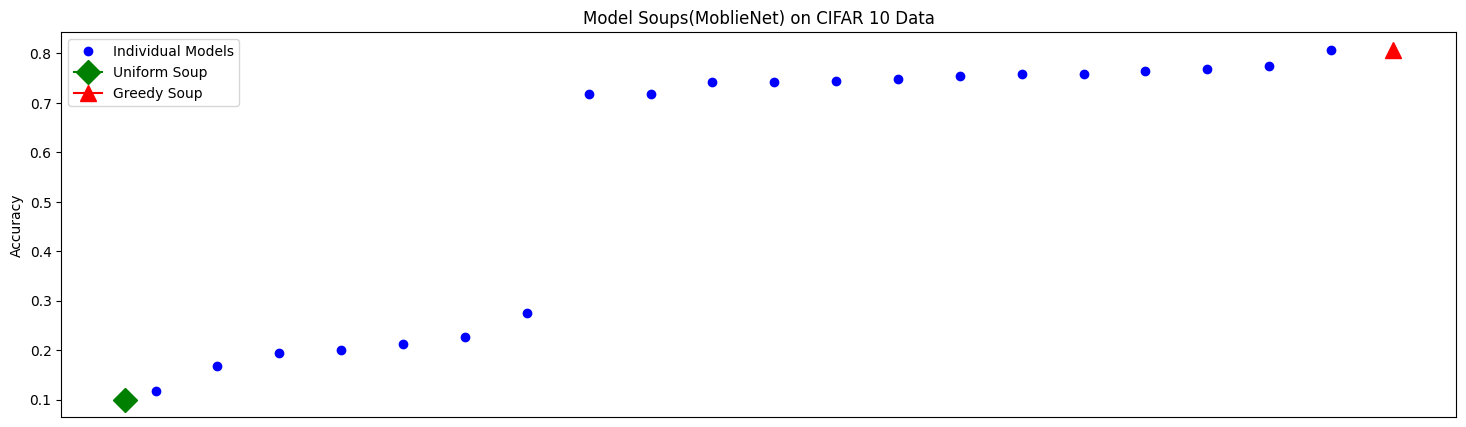

In [ ]:
uniform_soup_pos = cifar_params[cifar_params["scores"].values[::-1] > uniform_soup_acc].index[0] - 0.5

fig, ax = plt.subplots(figsize = (18,5))
plt.plot( cifar_params["scores"].values[::-1], "bo", label = "Individual Models")
plt.plot( uniform_soup_pos,uniform_soup_acc,  marker= "D", color = "green", markersize = 12, label = "Uniform Soup")
plt.plot( len(cifar_params), greedy_soup_acc,  marker= "^", color = "red", markersize = 12, label = "Greedy Soup")
ax.get_xaxis().set_visible(False)
plt.ylabel("Accuracy")
plt.title("Model Soups(ResNet) on CIFAR 10 Data")
plt.legend();